<a href="https://colab.research.google.com/github/ranieri-unimi/git.ammagamma/blob/main/colab_data_download_analysis_and_forecasting_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on time

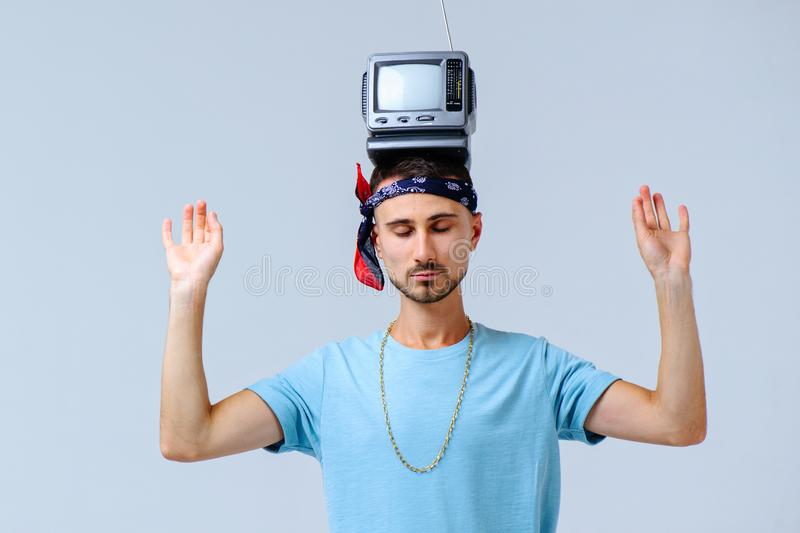

In this lab we'll follow the next steps:
1. Downnload data using Yahoo Finance API
2. Explore and analyze data
3. Learn how to deal with forecasting models - Prophet

In [ ]:
# *IMPORT LIBRARIES USED*

!pip install fbprophet
!pip install yfinance

from fbprophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 487 kB/s 
     |████████████████████████████████| 6.4 MB 10.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**yfinance**

"Ever since Yahoo! finance decommissioned their historical data API, many programs that relied on it to stop working.

yfinance aimes to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance."

https://pypi.org/project/yfinance/

# 1. Download data 

Definition of an analysis starting and ending period

In [ ]:
start = pd.to_datetime('2010-01-01')
end = date.today()
#custom_end = pd.to_datetime('2022-05-22')
#end = custom_end

Definition of a list of Ticker: in yfinance you need to specify the rate needed in the following format:  't_currency1t_currency2=X'.

In [ ]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

Download the previous tickers only for Close prices

In [ ]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
forex_df

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-01      1.438994      1.613294       1.03390     92.919998   
2010-01-04      1.442398      1.611370       1.02910     92.495003   
2010-01-05      1.436596      1.599079       1.03370     91.584999   
2010-01-06      1.440403      1.602384       1.02760     92.356003   
2010-01-07      1.431803      1.593397       1.03360     93.389999   
...                  ...           ...           ...           ...   
2022-05-26      1.068661      1.258610       0.96153    127.152000   
2022-05-27      1.073295      1.261734       0.95856    127.044998   
2022-05-30      1.073146      1.262834       0.95785    127.285004   
2022-05-31      1.077354      1.264702       0.95823    127.783997   
2022-06-01      1.069404      1.251737       0.96255    129.634003   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-01    133.710007       1.05120      0.898473  
2010-01-04    133.389999       1.04100      0.912492  
2010-01-05    131.529999       1.03950      0.911826  
2010-01-06    133.013000       1.03190      0.920471  
2010-01-07    133.748001       1.03400      0.917768  
...                  ...           ...           ...  
2022-05-26    135.871994       1.28202      0.708940  
2022-05-27    136.339996       1.27730      0.709879  
2022-05-30    136.587997       1.27237      0.716281  
2022-05-31    137.660004       1.26552      0.719520  
2022-06-01    138.529999       1.26239      0.720742  

[3237 rows x 7 columns]

# 2. Data exploration

### Check missing values and fill if needed

In [ ]:
# nan values do exist
forex_df[forex_df.isnull().any(axis=1)]

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2011-04-15      1.443210           NaN           NaN           NaN   
2012-01-27      1.309278      1.568209           NaN     77.459999   
2012-01-31      1.313957      1.570845           NaN     76.360001   
2012-12-04           NaN      1.609787           NaN     82.133003   
2013-10-08           NaN           NaN           NaN           NaN   
2019-05-22           NaN           NaN           NaN           NaN   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2011-04-15           NaN           NaN           NaN  
2012-01-27    101.421997        1.0024      1.061582  
2012-01-31    100.330002        1.0024      1.058604  
2012-12-04    107.301003           NaN           NaN  
2013-10-08    131.289993           NaN           NaN  
2019-05-22    123.438004           NaN           NaN

Multiple strategies can be used to fill missing values, these depend on the nature of the problem (but be aware of the consequences):

- use median, mode, mean values
- use a statistical method: regression, nearest neighbors
- back/forward fill, **interpolate**
- drop missing data 

In [ ]:
# fillna fills with given value or method: in this case forward fill
forex_df.fillna(method='ffill', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-15 00:00:00, dtype: float64

In [ ]:
forex_df.loc['2011-04-14']

eurusd_close      1.444210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-14 00:00:00, dtype: float64

In [ ]:
# interpolate interpolates given a method
forex_df.interpolate(method='linear', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.629145
usdchf_close      0.894250
usdjpy_close     83.465000
eurjpy_close    120.417999
usdcad_close      0.961300
audusd_close      1.053002
Name: 2011-04-15 00:00:00, dtype: float64

In [ ]:
forex_df.loc[['2011-04-14', '2011-04-15', '2011-04-18']]

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2011-04-14      1.444210      1.626889        0.8959     83.782997   
2011-04-15      1.443210           NaN           NaN           NaN   
2011-04-18      1.441296      1.631401        0.8926     83.147003   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2011-04-14    121.000000        0.9626      1.049803  
2011-04-15           NaN           NaN           NaN  
2011-04-18    119.835999        0.9600      1.056201

In [ ]:
# let's use interpolation since we are dealing with time series data
forex_df.interpolate(method='linear', axis=0, inplace=True)
# double check on missing data
forex_df[forex_df.isnull().any(axis=1)]

Empty DataFrame
Columns: [eurusd_close, gbpusd_close, usdchf_close, usdjpy_close, eurjpy_close, usdcad_close, audusd_close]
Index: []

In [ ]:
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3237 entries, 2010-01-01 to 2022-06-01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eurusd_close  3237 non-null   float64
 1   gbpusd_close  3237 non-null   float64
 2   usdchf_close  3237 non-null   float64
 3   usdjpy_close  3237 non-null   float64
 4   eurjpy_close  3237 non-null   float64
 5   usdcad_close  3237 non-null   float64
 6   audusd_close  3237 non-null   float64
dtypes: float64(7)
memory usage: 331.4 KB


In [ ]:
forex_df.describe()

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  eurjpy_close  \
count   3237.000000   3237.000000   3237.000000   3237.000000   3237.000000   
mean       1.215637      1.444922      0.954956    103.010845    124.095197   
std        0.108346      0.142371      0.051054     13.397394     10.918304   
min        1.037958      1.149439      0.722800     75.739998     94.209999   
25%        1.122297      1.309380      0.919440     93.434998    117.260002   
50%        1.185171      1.441545      0.958300    107.178001    125.674004   
75%        1.313198      1.571833      0.988140    111.858002    131.796997   
max        1.484406      1.716090      1.162700    130.811005    149.440994   

       usdcad_close  audusd_close  
count   3237.000000   3237.000000  
mean       1.191969      0.830278  
std        0.140139      0.127562  
min        0.943200      0.574290  
25%        1.033190      0.726744  
50%        1.254530      0.772300  
75%        1.313600      0.935804  
max        1.457800      1.103497

### Visualize data

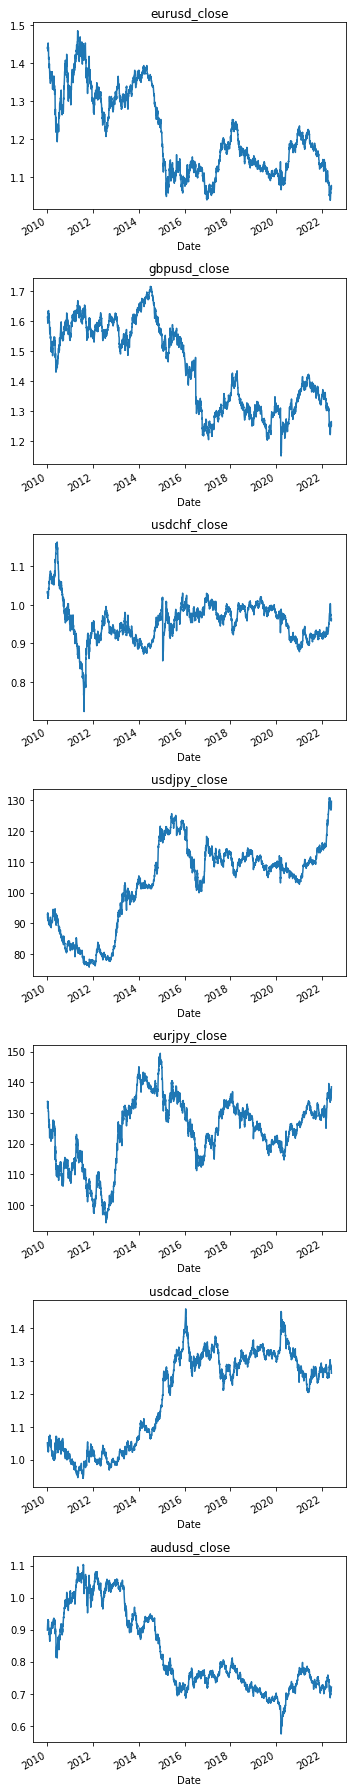

In [ ]:
fig, ax = plt.subplots(forex_df.shape[1],1, figsize=(5,25))
for idx, col in enumerate(forex_df):
  forex_df[col].plot(ax=ax[idx])
  ax[idx].set_title(col)
fig.tight_layout()

In [ ]:
# Looking for something fancier? go for plotly :-)

for idx, col in enumerate(forex_df):
  fig = px.line(forex_df, y=col)
  fig.show()

Scaling the changes using by percentange change, in order to remove differences between pricing, scaling is also vital to perform the Value at Risk calculation and for a statistical analysis.

1. For risk analysis we are more interested in daily changes than in the absolute value of the rate. (e.g. for VaR analysis)

In [ ]:
forex_rate_df = forex_df.pct_change(axis='rows')
forex_rate_df_clean = forex_rate_df.dropna(axis=0)

In [ ]:
# New Dataframe cleaned
forex_rate_df_clean

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-04      0.002366     -0.001192     -0.004643     -0.004574   
2010-01-05     -0.004022     -0.007628      0.004470     -0.009838   
2010-01-06      0.002650      0.002067     -0.005901      0.008418   
2010-01-07     -0.005971     -0.005609      0.005839      0.011196   
2010-01-08      0.006499      0.005657     -0.009675     -0.007817   
...                  ...           ...           ...           ...   
2022-05-26     -0.004649      0.003440      0.001385      0.003021   
2022-05-27      0.004336      0.002482     -0.003089     -0.000842   
2022-05-30     -0.000140      0.000871     -0.000741      0.001889   
2022-05-31      0.003921      0.001480      0.000397      0.003920   
2022-06-01     -0.007379     -0.010252      0.004508      0.014478   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-04     -0.002393     -0.009703      0.015604  
2010-01-05     -0.013944     -0.001441     -0.000729  
2010-01-06      0.011275     -0.007311      0.009481  
2010-01-07      0.005526      0.002035     -0.002937  
2010-01-08     -0.001929     -0.004062      0.007956  
...                  ...           ...           ...  
2022-05-26     -0.001396     -0.000172     -0.001943  
2022-05-27      0.003444     -0.003682      0.001325  
2022-05-30      0.001819     -0.003860      0.009018  
2022-05-31      0.007848     -0.005384      0.004522  
2022-06-01      0.006320     -0.002473      0.001697  

[3236 rows x 7 columns]

Aggregated Returns plot 

In [ ]:
fig = go.Figure()

for ticker in forex_rate_df_clean.columns:

  # Only thing I figured is - I could do this 
  fig.add_scatter(
                  x=forex_rate_df_clean.index,
                  y=forex_rate_df_clean[f'{ticker}'],
                  name=f'{ticker}'
                ) # Not what is desired - need a line 

# Show plot 
fig.show()

### Standard Deviation of the different rates of returns.

In [ ]:
for ticker in forex_rate_df_clean.columns:
  fig = px.histogram(forex_rate_df_clean, x=ticker,
                    marginal="rug", template="plotly_white",
                    hover_data=forex_rate_df_clean.columns, 
                    title=f'Distribution of {ticker} the std related to it is {np.round(forex_rate_df_clean[ticker].std(), 3)}')
  fig.show()

Correlation analysis between numerical variables. 

In [ ]:
fig = px.scatter_matrix(forex_rate_df_clean,
                        dimensions=forex_rate_df_clean.columns.to_list(),
                        height=1000, width=1000, 
                        template='plotly_white'
                        )

fig.update_traces(diagonal_visible=False)
fig.show()

### Pearson Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

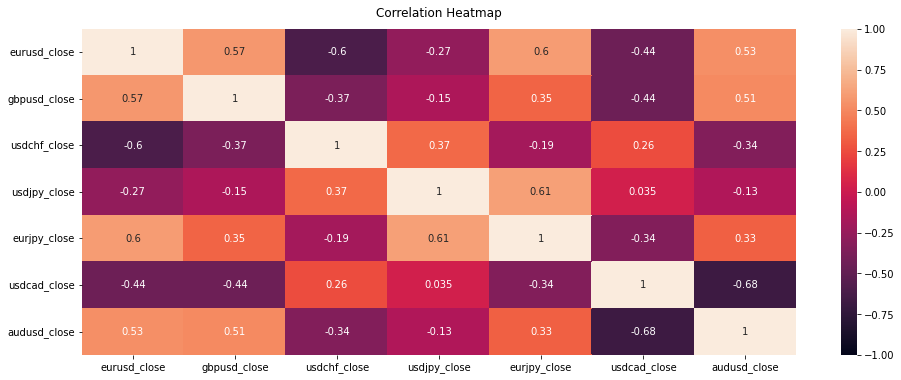

In [ ]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(forex_rate_df_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# 3. Forecasting Method - Prophet

Prophet is a library developed by Facebook for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well (Facebook-Prophet website: https://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,daily%20seasonality%2C%20plus%20holiday%20effects.&text=Prophet%20is%20open%20source%20software,download%20on%20CRAN%20and%20PyPI.)

In order to forecast the SINGLE series in the future we need to:
1. ALWAYS add an additional column related to the y variable (in our scenario equal to eurgbp_close) to df['y']
2. ALWAYS Reset the index of the series and rename the column with the date in df['ds']

In [ ]:
forex_df

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-01      1.438994      1.613294       1.03390     92.919998   
2010-01-04      1.442398      1.611370       1.02910     92.495003   
2010-01-05      1.436596      1.599079       1.03370     91.584999   
2010-01-06      1.440403      1.602384       1.02760     92.356003   
2010-01-07      1.431803      1.593397       1.03360     93.389999   
...                  ...           ...           ...           ...   
2022-05-26      1.068661      1.258610       0.96153    127.152000   
2022-05-27      1.073295      1.261734       0.95856    127.044998   
2022-05-30      1.073146      1.262834       0.95785    127.285004   
2022-05-31      1.077354      1.264702       0.95823    127.783997   
2022-06-01      1.069404      1.251737       0.96255    129.634003   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-01    133.710007       1.05120      0.898473  
2010-01-04    133.389999       1.04100      0.912492  
2010-01-05    131.529999       1.03950      0.911826  
2010-01-06    133.013000       1.03190      0.920471  
2010-01-07    133.748001       1.03400      0.917768  
...                  ...           ...           ...  
2022-05-26    135.871994       1.28202      0.708940  
2022-05-27    136.339996       1.27730      0.709879  
2022-05-30    136.587997       1.27237      0.716281  
2022-05-31    137.660004       1.26552      0.719520  
2022-06-01    138.529999       1.26239      0.720742  

[3237 rows x 7 columns]

In [ ]:
# In order to forecast the series we need to: 1. 
# 1)
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values

forex_df.tail()

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2022-05-26      1.068661      1.258610       0.96153    127.152000   
2022-05-27      1.073295      1.261734       0.95856    127.044998   
2022-05-30      1.073146      1.262834       0.95785    127.285004   
2022-05-31      1.077354      1.264702       0.95823    127.783997   
2022-06-01      1.069404      1.251737       0.96255    129.634003   

            eurjpy_close  usdcad_close  audusd_close         ds         y  
Date                                                                       
2022-05-26    135.871994       1.28202      0.708940 2022-05-26  1.068661  
2022-05-27    136.339996       1.27730      0.709879 2022-05-27  1.073295  
2022-05-30    136.587997       1.27237      0.716281 2022-05-30  1.073146  
2022-05-31    137.660004       1.26552      0.719520 2022-05-31  1.077354  
2022-06-01    138.529999       1.26239      0.720742 2022-06-01  1.069404

Create train and test, test used in prophet only for backtesting reason!

In [ ]:
# define test and train window
train_window =  ['2010-01-03','2020-10-31']
test_window =  ['2020-11-01','2021-06-10']

In [ ]:
# create train and test dataset
train = forex_df[train_window[0]:train_window[1]]
test = forex_df[test_window[0]:test_window[1]]


In [ ]:
m = Prophet()
m.fit(train[['ds', 'y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(20, freq='B')

In [ ]:
future

ds
0    2010-01-04
1    2010-01-05
2    2010-01-06
3    2010-01-07
4    2010-01-08
...         ...
2838 2020-11-23
2839 2020-11-24
2840 2020-11-25
2841 2020-11-26
2842 2020-11-27

[2843 rows x 1 columns]

In [ ]:
future = m.make_future_dataframe(20, freq='B') # Explain B
forecast = m.predict(future)

forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)
forecast_results.set_index('ds', inplace=True)

In [ ]:
forecast_results

yhat  yhat_lower  yhat_upper
ds                                          
2020-11-02  1.133844    1.104358    1.161780
2020-11-03  1.132541    1.103022    1.162161
2020-11-04  1.131199    1.101873    1.160813
2020-11-05  1.129826    1.100690    1.158278
2020-11-06  1.128527    1.098992    1.156754
2020-11-09  1.124215    1.094926    1.152255
2020-11-10  1.122926    1.093184    1.150865
2020-11-11  1.121695    1.091844    1.149429
2020-11-12  1.120526    1.090533    1.154270
2020-11-13  1.119521    1.092014    1.146715
2020-11-16  1.116574    1.090129    1.147148
2020-11-17  1.115877    1.088529    1.146359
2020-11-18  1.115289    1.086766    1.143807
2020-11-19  1.114805    1.084734    1.143515
2020-11-20  1.114514    1.085151    1.142576
2020-11-23  1.113776    1.083737    1.141853
2020-11-24  1.113796    1.085512    1.143858
2020-11-25  1.113897    1.084726    1.144058
2020-11-26  1.114064    1.083503    1.145101
2020-11-27  1.114376    1.087148    1.142030

In [ ]:
final_df_results = pd.merge(test[['eurusd_close']], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')

In [ ]:
final_df_results

eurusd_close      yhat
2020-11-02      1.164212  1.133844
2020-11-03      1.164280  1.132541
2020-11-04      1.176221  1.131199
2020-11-05      1.173268  1.129826
2020-11-06      1.181754  1.128527
2020-11-09      1.189301  1.124215
2020-11-10      1.182732  1.122926
2020-11-11      1.181879  1.121695
2020-11-12      1.178030  1.120526
2020-11-13      1.180339  1.119521
2020-11-16      1.184525  1.116574
2020-11-17      1.185944  1.115877
2020-11-18      1.186366  1.115289
2020-11-19      1.184764  1.114805
2020-11-20      1.186648  1.114514
2020-11-23      1.186648  1.113776
2020-11-24      1.184273  1.113796
2020-11-25      1.190051  1.113897
2020-11-26      1.192000  1.114064
2020-11-27      1.191600  1.114376

## Model evaluation and scores

In [ ]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae https://en.wikipedia.org/wiki/Mean_absolute_error
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse https://en.wikipedia.org/wiki/Root-mean-square_deviation
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias https://en.wikipedia.org/wiki/Bias_(statistics)
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()


Mean MAE: 0.06
MAE%: 5.21%
RMSE: 0.06
Bias: -0.06

5th percetile MAE: 0.03
25th percetile MAE: 0.06
50th percetile MAE: 0.07
75th percetile MAE: 0.07
95th percetile MAE: 0.08


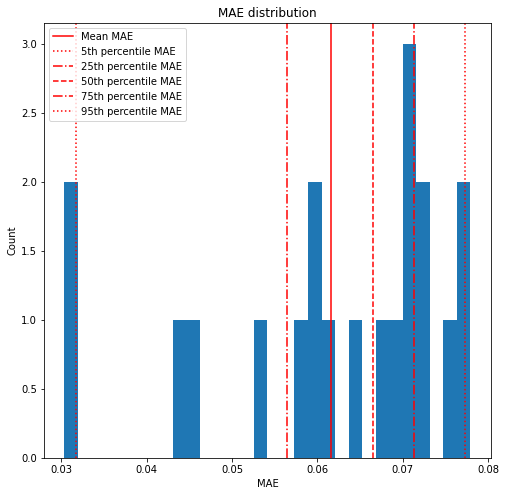

In [ ]:
# Analyze the forecast error
calc_errors(final_df_results['eurusd_close'].values, final_df_results['yhat'].values)


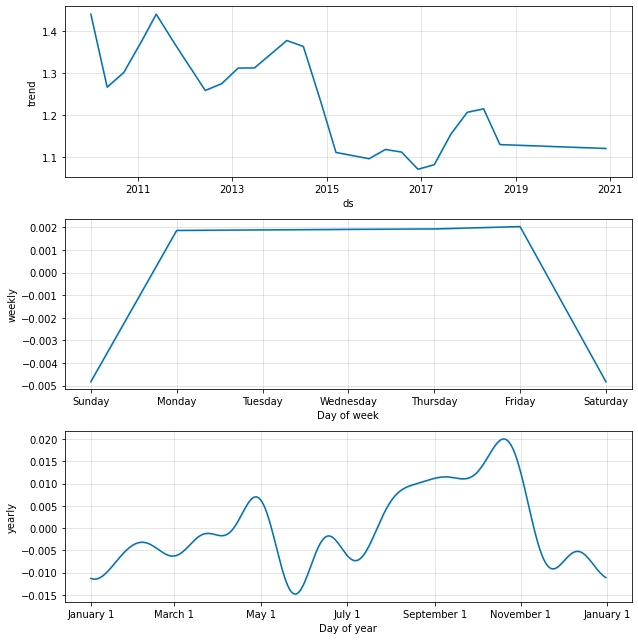

In [ ]:
# explore the components of the fitted model
fig = m.plot_components(forecast)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

### Short long story: work hard for nothing

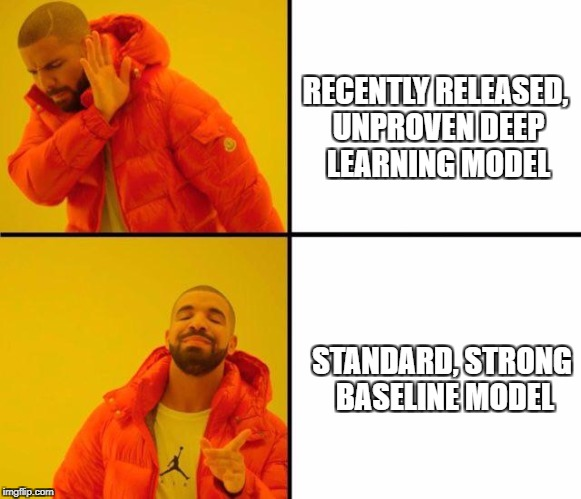

Let's have a look if "stupid" model is able to make better prediction than our method. We are going to shift the value of EURUSD change and use the value of 7 days ago to predict the value of EURUSD for tomorrow

In [ ]:
final_df_results


eurusd_close      yhat
2020-11-02      1.164212  1.133844
2020-11-03      1.164280  1.132541
2020-11-04      1.176221  1.131199
2020-11-05      1.173268  1.129826
2020-11-06      1.181754  1.128527
2020-11-09      1.189301  1.124215
2020-11-10      1.182732  1.122926
2020-11-11      1.181879  1.121695
2020-11-12      1.178030  1.120526
2020-11-13      1.180339  1.119521
2020-11-16      1.184525  1.116574
2020-11-17      1.185944  1.115877
2020-11-18      1.186366  1.115289
2020-11-19      1.184764  1.114805
2020-11-20      1.186648  1.114514
2020-11-23      1.186648  1.113776
2020-11-24      1.184273  1.113796
2020-11-25      1.190051  1.113897
2020-11-26      1.192000  1.114064
2020-11-27      1.191600  1.114376

In [ ]:
final_df_results['yhat_baselinemodel'] = final_df_results['eurusd_close'].rolling(7).mean()

Mean MAE: 0.07
MAE%: 5.63%
RMSE: 0.07
Bias: -0.07

5th percetile MAE: 0.06
25th percetile MAE: 0.06
50th percetile MAE: 0.07
75th percetile MAE: 0.07
95th percetile MAE: 0.07


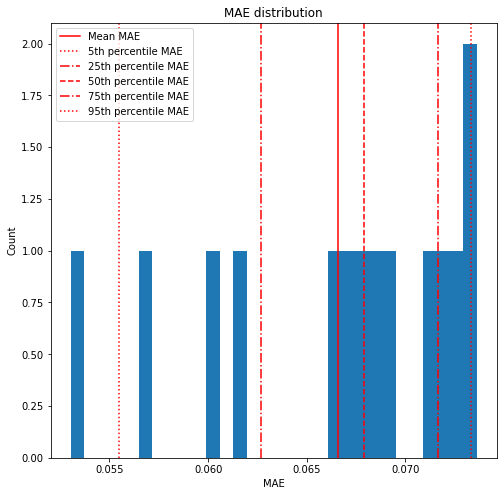

In [ ]:
# Analyze the forecast error
calc_errors(final_df_results.dropna()['yhat_baselinemodel'].values, final_df_results.dropna()['yhat'].values)


## Improve forecasting perfomances : hyperparameter tuning and extra regressors

### Download useful data

In [ ]:
def get_new_data():
    url_extra = 'https://drive.google.com/file/d/1CT91MvzT2-WLK6rTdDu4-vBdj0kyfDP5/view?usp=sharing'
    url_covid = 'https://drive.google.com/file/d/1ZlwZtSdtxlTlP2RUZtYjqpVSiaXMEzXO/view?usp=sharing'

 

    file_id = url_extra.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_extra = pd.read_csv(dwn_url, parse_dates=['DATE'])

 

    file_id = url_covid.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_covid = pd.read_csv(dwn_url, parse_dates=['date'])

 

    return df_extra, df_covid

The first step is download the extraregressor data. For this purpose we have prepare two different dataset, containing GDP, inflation and COVID-19 data

In [ ]:
extra_df, df_covid = get_new_data()

In [ ]:
extra_df.set_index('DATE',inplace=True)
# remap column name
map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation'}
extra_df = extra_df.rename(columns=map_dict)
# group data for each continent and sum the number of new cases
df_covid_g = df_covid.groupby(['continent','date']).agg({'new_cases':'sum'})


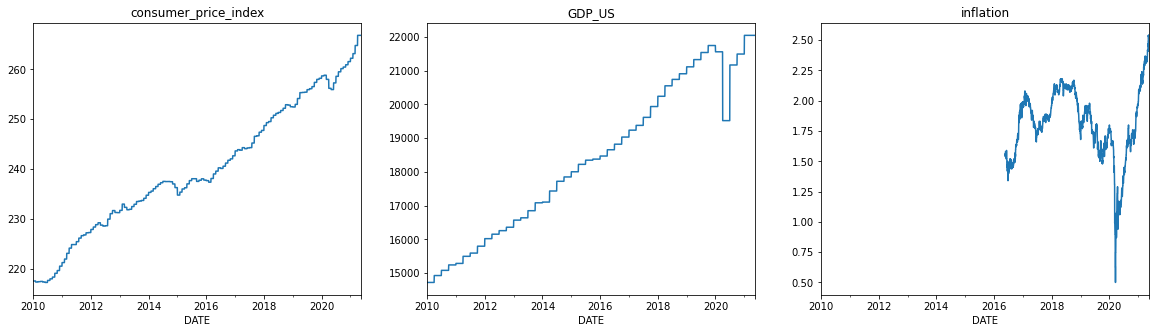

In [ ]:
# plot timeseries
fig, ax = plt.subplots(1,3, figsize=(20,5))
for idx, col in enumerate(extra_df):
  extra_df[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

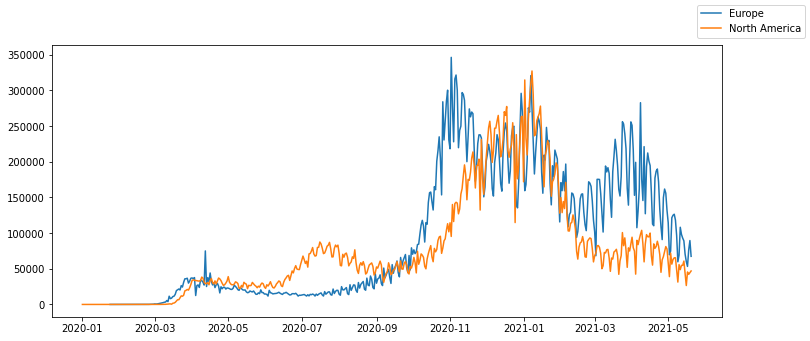

In [ ]:
# compare Europe and North America time series
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_covid_g.loc['Europe'], label='Europe')
ax.plot(df_covid_g.loc['North America'], label='North America')
fig.legend()

### Timeseries correlation

In [ ]:
# merge the data in a single dataframe to explore timeseries correlation
forex_df_reg = forex_df.merge(extra_df, left_index=True, right_index=True, how='left')

In [ ]:
forex_df_reg = forex_df_reg.merge(df_covid_g.loc['North America'].rename(columns={'new_cases':'covid_US'}), left_index=True, right_index=True, how='left')
forex_df_reg = forex_df_reg.merge(df_covid_g.loc['Europe'].rename(columns={'new_cases':'covid_EU'}), left_index=True, right_index=True, how='left')
forex_df_reg['covid_US'] = forex_df_reg['covid_US'].fillna(0)
forex_df_reg['covid_EU'] = forex_df_reg['covid_EU'].fillna(0)

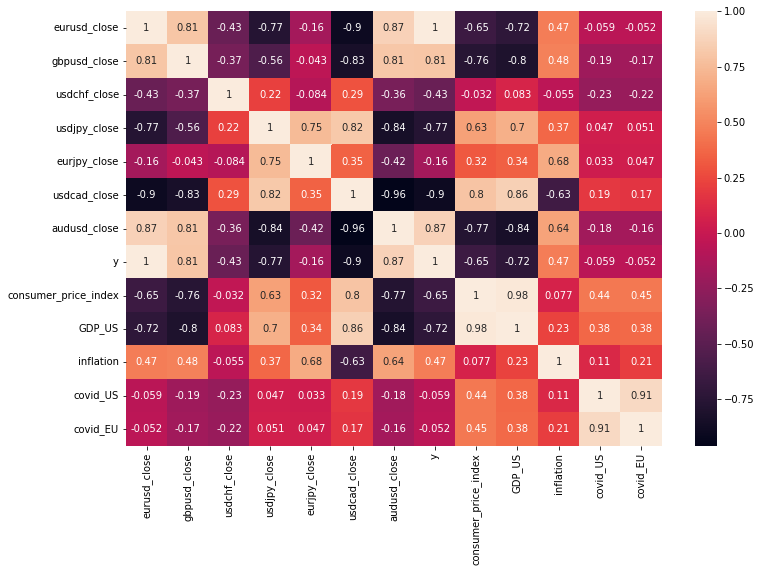

In [ ]:
# explore correlation
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(forex_df_reg.corr(), annot=True, ax=ax)

### Forecasting using extra regressors with Prophet

In [ ]:
# create train and test dataset
forex_df_reg = forex_df_reg.dropna()
train = forex_df_reg[train_window[0]:train_window[1]]
test = forex_df_reg[test_window[0]:test_window[1]]

In [ ]:
# define Prophet model with hyperparameters
m = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)
# add custom seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=15)
# add extra regressor
extra_regressor = ['consumer_price_index','GDP_US','inflation', 'covid_US', 'covid_EU']
for reg in extra_regressor:
  m.add_regressor(name=reg, mode='additive')

In [ ]:
# train model
m.fit(train)

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# make future dataframe and predict
future = m.make_future_dataframe(test.shape[0], freq='B') # Explain B
forecast = m.predict(future.merge(forex_df_reg[extra_regressor], left_on='ds', right_index=True, how='left').fillna(method='pad'))

forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_results.set_index('ds', inplace=True)

In [ ]:
future.merge(forex_df_reg[extra_regressor], left_on='ds', right_index=True, how='left').fillna(method='pad')

ds  consumer_price_index     GDP_US  inflation  covid_US  \
0    2016-05-20               239.557  18656.207       1.56       0.0   
1    2016-05-23               239.557  18656.207       1.54       0.0   
2    2016-05-24               239.557  18656.207       1.55       0.0   
3    2016-05-25               239.557  18656.207       1.58       0.0   
4    2016-05-26               239.557  18656.207       1.58       0.0   
...         ...                   ...        ...        ...       ...   
1298 2021-05-14               266.832  22048.894       2.51   60795.0   
1299 2021-05-17               266.832  22048.894       2.54   45487.0   
1300 2021-05-18               266.832  22048.894       2.52   42170.0   
1301 2021-05-19               266.832  22048.894       2.48   44661.0   
1302 2021-05-20               266.832  22048.894       2.41   46958.0   

      covid_EU  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
...        ...  
1298   89157.0  
1299   53323.0  
1300   76497.0  
1301   89586.0  
1302   67466.0  

[1303 rows x 6 columns]

In [ ]:
final_df_results = pd.merge(test['eurusd_close'], forecast_results[['yhat']], left_index=True, right_index=True)

In [ ]:
final_df_results

eurusd_close      yhat
2020-11-02      1.164212  1.169958
2020-11-03      1.164280  1.178592
2020-11-04      1.176221  1.173431
2020-11-05      1.173268  1.174146
2020-11-06      1.181754  1.172799
...                  ...       ...
2021-05-14      1.207729  1.204518
2021-05-17      1.215037  1.205338
2021-05-18      1.215687  1.205371
2021-05-19      1.222400  1.204786
2021-05-20      1.217285  1.203822

[144 rows x 2 columns]

### Explore extra regressors effect

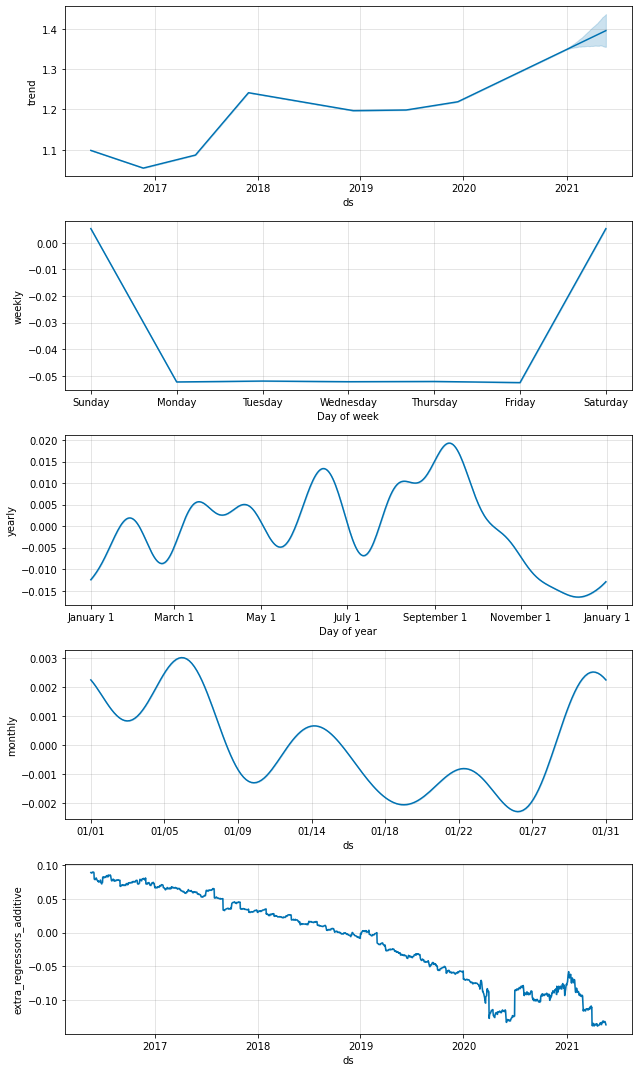

In [ ]:
# explore the components of the fitted model
fig = m.plot_components(forecast)

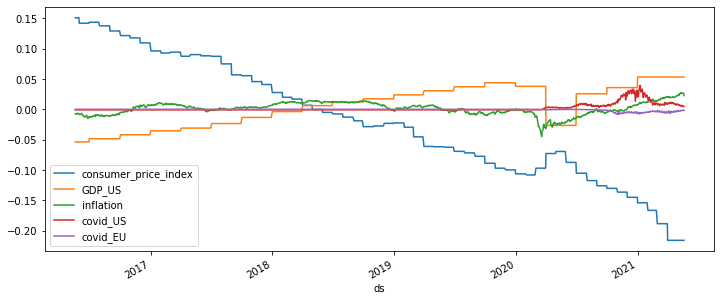

In [ ]:
# explore the role and weight of each extra regressor
fig, ax = plt.subplots(figsize=(12,5))
forecast.set_index('ds')[extra_regressor].plot(ax=ax)

In [ ]:
# explore results on the forecast window
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

Mean MAE: 0.01
MAE%: 1.08%
RMSE: 0.02
Bias: 0.00

5th percetile MAE: 0.00
25th percetile MAE: 0.00
50th percetile MAE: 0.01
75th percetile MAE: 0.02
95th percetile MAE: 0.03


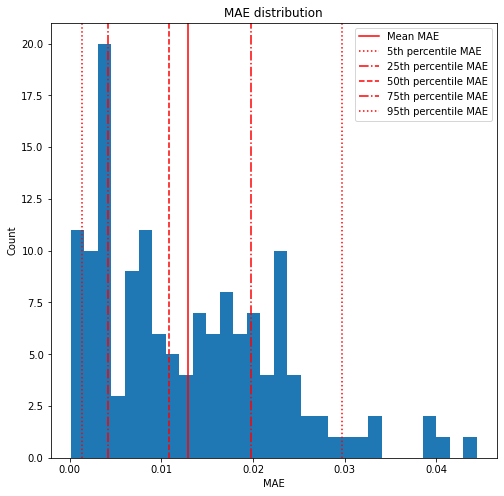

In [ ]:
# Analyze the forecast error
calc_errors(final_df_results['eurusd_close'].values, final_df_results['yhat'].values)

# "Forecasting"

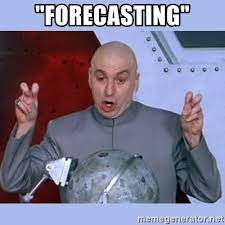

**??What's wrong with our approach??**

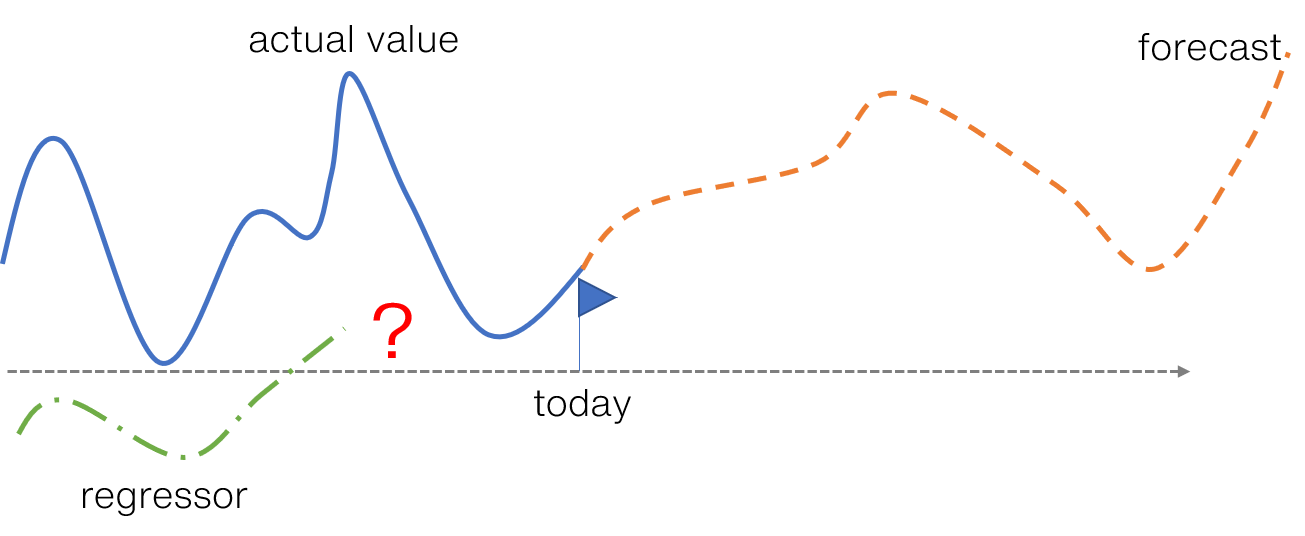

# Homework!

- Forecast the EURUSD change for the upcoming 2 weeks using a "deploy" approach:
  - Use only data available at the moment your are forecasting


Tips: Which information are available today that could improve my model performances?

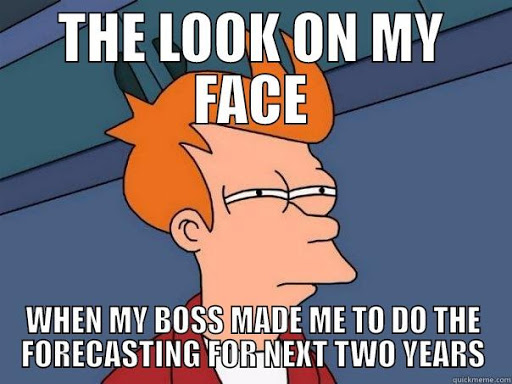

# Useful links

- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python data analysis example
- https://fred.stlouisfed.org Financial timeseries
- Seasonality and Regressors - Example https://towardsdatascience.com/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda
- Seasonality and Regressors - Documentation https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
-  FbProphet usecase - https://futurice.com/blog/business-forecasting-with-facebook-prophet